### Импортирование необходимых библиотек

In [366]:
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer,average_precision_score
import skopt
import warnings

### Выгрузка исходного датафрейма

In [367]:
df = pd.read_csv('tokens.csv')
# Преобразования столбца start_time в формат datetime
df['start_time'] = pd.to_datetime(df['start_time'])

### Обработка пропущенных значений

In [368]:
# Определение пропущенных значений в датафрейме
missing_values = df.isnull().sum()

# Проверка наличия пропущенных значений
if missing_values.any():
    print("Столбцы с пропущенными значениями:")
    print(missing_values[missing_values > 0])
else:
    print("Пропущенных значений нет.")

# В переменной max_eth_1st содержатся вещественные числа, и пропуски в данном случае следует заменить средним значением. 
# Однако, в силу очень малого количества пропусков мы можем просто удалить данные строки из фрейма:
df = df.dropna().reset_index(drop=True)

Столбцы с пропущенными значениями:
max_eth_1st    6
dtype: int64


### Разделение данных на обучающую и тестовую выборки

In [369]:
split_date = pd.to_datetime('2023-12-06 00:00:00')
df_train = df[df['start_time'] < split_date]
df_test = df[df['start_time'] >= split_date]

### Визуализация кол-ва наблюдений в тестовой и тренировочной выборках

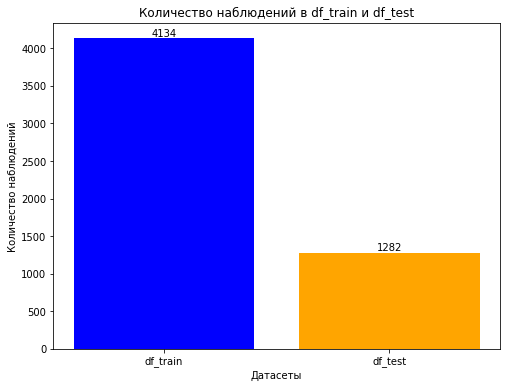

In [370]:
train_obs_count = len(df_train)
test_obs_count = len(df_test)

plt.figure(figsize=(8, 6))
plt.bar(['df_train', 'df_test'], [train_obs_count, test_obs_count], color=['blue', 'orange'])

for i, count in enumerate([train_obs_count, test_obs_count]):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.title('Количество наблюдений в df_train и df_test')
plt.xlabel('Датасеты')
plt.ylabel('Количество наблюдений')

plt.show()


### Изучение распределения значений в переменной 6h_5m

In [371]:
df_train_no_outliers = df_train[df_train['6h_5m'] <= 1]

fig = make_subplots(rows=1, cols=2, subplot_titles=('Гистограмма исходных данных', 'Гистограмма данных после удаления выбросов'))

fig.add_trace(go.Histogram(x=df_train['6h_5m'], nbinsx=200), row=1, col=1)
fig.add_trace(go.Histogram(x=df_train_no_outliers['6h_5m'], nbinsx=50), row=1, col=2)
fig.update_layout(title_text='6h_5m', showlegend=False)
fig.show()

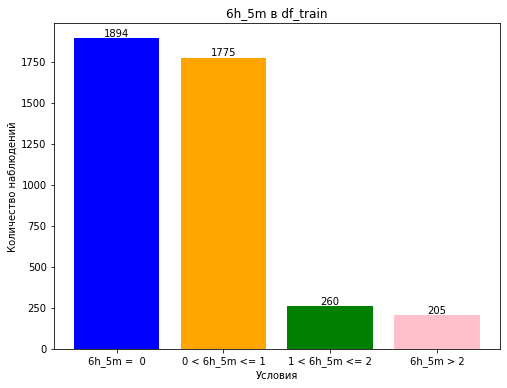

In [372]:
values = df_train['6h_5m']

# Условия для группировки значений
condition_1 = (values == 0)
condition_2 = (values > 0) & (values <= 1)
condition_3 = (values > 1) & (values <= 2)
condition_4 = (values >= 2)

# Определение количества значений для каждого условия
count_1 = len(values[condition_1])
count_2 = len(values[condition_2])
count_3 = len(values[condition_3])
count_4 = len(values[condition_4])

plt.figure(figsize=(8, 6))
plt.bar(['6h_5m =  0', '0 < 6h_5m <= 1', '1 < 6h_5m <= 2', '6h_5m > 2'], [count_1, count_2, count_3, count_4], color=['blue', 'orange', 'green', 'pink'])
for i, count in enumerate([count_1, count_2, count_3, count_4]):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.title('6h_5m в df_train')
plt.xlabel('Условия')
plt.ylabel('Количество наблюдений')

plt.show()

### Устранение мультиколлинеарности 

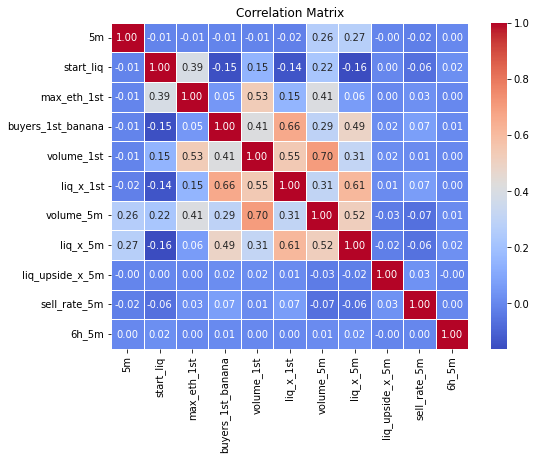

In [373]:
def delete_multicollinearity(df, y_name: str, level: float):
    import numpy as np
    y = df[y_name].to_list()
    df.drop([y_name], axis=1, inplace=True)
    max_corr = 1
    while max_corr > level:
        corr_x = df.corr()
        column_x = corr_x.columns.values.tolist() 
        start_column = 1
        max_corr = 0
        max_row, max_col = 0, 0

        for row in range(len(corr_x)):
            for col in range(start_column, len(column_x)):
                if abs(corr_x.iloc[row, col]) > max_corr:
                    max_corr = abs(corr_x.iloc[row, col])
                    max_row = row
                    max_col = col
            start_column += 1

        cor1 = np.corrcoef(y, df[column_x[max_col]])[0, 1]
        cor2 = np.corrcoef(y, df[column_x[max_row]])[0, 1]

        if cor1 > cor2:
            df.drop([column_x[max_row]], axis=1, inplace=True)
        else:
            df.drop([column_x[max_col]], axis=1, inplace=True)
    else:
        df[y_name] = y
        return df
    

df_train_clear =  delete_multicollinearity(df_train.copy(), "6h_5m", 0.75)

# Удаление лишних регрессоров из выборок
df_train = df_train_clear.copy()
df_test = df_test.loc[:, df_train.columns]

correlation_matrix = df_train_clear.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

### Изучение распределения классов в обучающей выборке

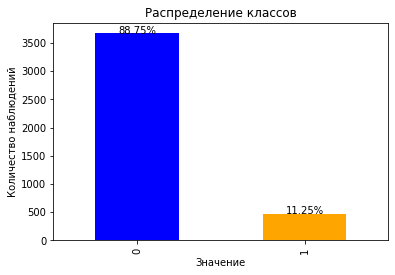

In [374]:
df_train['positive'] = df_train['6h_5m'].apply(lambda x: 1 if x > 1 else 0)
plt.figure(figsize=(6, 4))
df_train['positive'].value_counts().sort_index().plot(kind='bar', color=['blue', 'orange'])
plt.title('Распределение классов')
plt.xlabel('Значение')
plt.ylabel('Количество наблюдений')

total = len(df_train['positive'])
for i, value in enumerate(df_train['positive'].value_counts().sort_index()):
    plt.text(i, value + 0.1, f'{value/total*100:.2f}%', ha='center')

plt.show()

### Обучение модели классификации Random Forest

In [ ]:
def random_forest_function(n_estimator,max_feature, max_depth):
    # Предобработка данных
    y_train = df_train['positive'].to_list()
    X_train = df_train.iloc[:, 2:-2]

    # Построение модели с определенными параметрами
    rf_model = RandomForestClassifier(n_estimators = n_estimator, class_weight='balanced', max_features = max_feature, max_depth = max_depth, random_state = 42)

    # Cтратифицированное разбиение данных на подвыборки для кросс-валидации: 
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    # StratifiedKFold обеспечивает, что распределение классов в каждом фолде остается примерно таким же, как в исходном наборе данных, 
    # что существенно улучшает качество обучения модели в случае сильного дисбаланса классов
    
    # В качестве метрики качества модели будет использована метрика Precision-Recall (PR-AUC) т.к.
    # эта метрика хорошо себя показывает при работе с несбалансированными классами
    pr_auc_scorer = make_scorer(average_precision_score)

    # Кросс-валидация
    cv_score = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring = pr_auc_scorer)

    return - np.mean(cv_score)
SPACE = [
    skopt.space.Categorical([50, 100, 150, 200, 250, 300, 400], name='n_estimator'),
    skopt.space.Categorical([4,5,6,7,8,9,10,12,14,16,18], name='max_feature'),
    skopt.space.Categorical([1,2,3,4,5,6], name='max_depth')]
@skopt.utils.use_named_args(SPACE)
def objective(**params):
    return random_forest_function(**params)

warnings.simplefilter("ignore")

# Подбор оптимальных гиперпараметров модели, максимизирующих значение PR-AUC
result = skopt.gp_minimize(objective, SPACE, n_calls=200, n_random_starts=200, n_jobs=-1, verbose=True)
best_metric = result.fun
print(f'Лучшее среднее значение PR-AUC: {best_metric}')
best_param = result.x
print(f'Лучшие параметры: {best_param}')


### Построение модели с оптимальными гиперпараметрами

In [364]:
X_train = df_train.iloc[:, 2:-2]
X_test = df_test.iloc[:, 2:-1]

random_forest_model = RandomForestClassifier(n_estimators=300, max_features = 16, max_depth = 1, random_state=42)
random_forest_model.fit(X_train, df_train['positive'])

# Получение прогнозов по тренировочной выборке
train_preds = random_forest_model.predict_proba(X_train).T.tolist()[1]

df_rm_preds_train = pd.DataFrame({'Prob': train_preds,
                                  '6h_5m': df_train['6h_5m']})


# Получение прогнозов по тестовой выборке
test_preds = random_forest_model.predict_proba(X_test).T.tolist()[1]

df_rm_preds_test = pd.DataFrame({'Prob': test_preds,
                                 '6h_5m': df_test['6h_5m']})

### Алгоритм отбора монет 

In [365]:
train_result = []
for n in range(1,1000):
    # Сортировка df_rm_preds_train по убыванию вероятностей предсказания класса 1 в столбце Prob
    sorted_df = df_rm_preds_train.sort_values(by='Prob', ascending=False)
    # Отбор топ - n самых вероятных по максимизации доходности монет
    top_df = sorted_df.head(n)
    # Определение общего "дохода" n монет
    sum_6h_5m = top_df['6h_5m'].sum()

    train_result.append(sum_6h_5m / len(top_df))

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,1000)), y=train_result, mode='lines', name='Доходности'))

fig.update_layout(
    title='График зависимости общей доходности от кол-ва "топовых" монет на тренировочной выборке',
    xaxis=dict(title='Кол-во "топовых по вероятности" монет'),
    yaxis=dict(title='Общая доходность'),
    showlegend=True,
    shapes=[
        go.layout.Shape(
            type="line",
            x0=118,
            x1=118,
            y0=min(train_result),
            y1=max(train_result),
            line=dict(color="red", width=2)
        )
    ]
)

fig.show()

# Из графика видно, что максимальная прибыль достигается при покупке 118 "топовых" монет и составляет 26.36 %

In [345]:
test_result = []
for i in range(1,1000):
    sorted_df = df_rm_preds_test.sort_values(by='Prob', ascending=False)
    top_df = sorted_df.head(i)
    sum_6h_5m = top_df['6h_5m'].sum()
    test_result.append(sum_6h_5m / len(top_df))

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,1000)), y=test_result, mode='lines', name='Доходности'))

fig.update_layout(
    title='График зависимости общей доходности от кол-ва "топовых" монет на тестовой выборке',
    xaxis=dict(title='Кол-во "топовых по вероятности" монет'),
    yaxis=dict(title='Общая доходность'),
    showlegend=True,
    shapes=[
        go.layout.Shape(
            type="line",
            x0=118,
            x1=118,
            y0=min(test_result),
            y1=max(test_result),
            line=dict(color="red", width=2)
        )
    ]
)

fig.show()

# На тестовом наборе данных использование 118 "топовых" монет показывает почти максимальный результат доходности
# Прибыль составляет 58.29%